In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import arviz as az
from cycler import cycler

from sphincter.data_preparation import load_prepared_data
from sphincter.plotting import plot_obs, plot_predictive, save_figure


CMAP = plt.get_cmap('Set2')

plt.rcParams['axes.prop_cycle'] = cycler(color=CMAP.colors)

In [2]:
abbreviations = {
    "post_ablation": "post abl.",
}

def format_name(name: str):
    return name.replace("_", " ").capitalize()


In [3]:
# def forestplot(ax, ts, xlabel="Value of test statistic"):
#     az.plot_forest(ts, ax=ax, combined=True, textsize=12, linewidth=3, hdi_prob=0.95);
#     ax.axvline(0.0, linestyle="--", color="black");
#     xlow, xhigh = ax.get_xlim();
#     xbiggest = max(abs(xlow), abs(xhigh))
#     ax.set_xlim(-xbiggest, xbiggest);
#     ax.set(title="", xlabel=xlabel);
#     return ax

def forestplot(ax, ts, xlabel="Value of test statistic", qlow=0.025, qhigh=0.975):
    ylimlow, ylimhigh = ax.get_ylim()
    ytickys = np.linspace(ylimlow, ylimhigh, len(ts)+2)
    ys = ytickys[1:-1]
    xlows = [np.quantile(t, qlow) for t in ts.values()]
    xhighs = [np.quantile(t, qhigh) for t in ts.values()]
    xmeans = [np.mean(t) for t in ts.values()]
    xbiggest = max(np.abs(xlows + xhighs)) + 0.1
    ax.set_xlim(-xbiggest, xbiggest)
    for y, xlow, xhigh, xmean in zip(ys, xlows, xhighs, xmeans):
        line = ax.hlines(y=y, xmin=xlow, xmax=xhigh, linewidth=2)
        ax.plot(xmean, y, marker="o", color=line.get_colors()[0])
    ax.set_yticks(ytickys, [""] + list(ts.keys()) + [""])
    # az.plot_forest(ts, ax=ax, combined=True, textsize=12, linewidth=3, hdi_prob=0.95);
    ax.axvline(0.0, linestyle="--", color="black");
    ax.set(title="", xlabel=xlabel);
    ax.tick_params(axis='y', which="both", left=False, right=False)
    return ax

### MAP, PP, HR (Figure 1)

In [4]:
idata_f1 = az.InferenceData.from_zarr(os.path.join("..", "inferences", "pressure", "idata"))

In [5]:
idata_f1

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> sample_stats_prior
	> observed_data

In [6]:
idata_f1.posterior.coords["treatment"].values

array(['baseline', 'hyper1', 'after_hyper1', 'ablation', 'hyper2'],
      dtype='<U12')

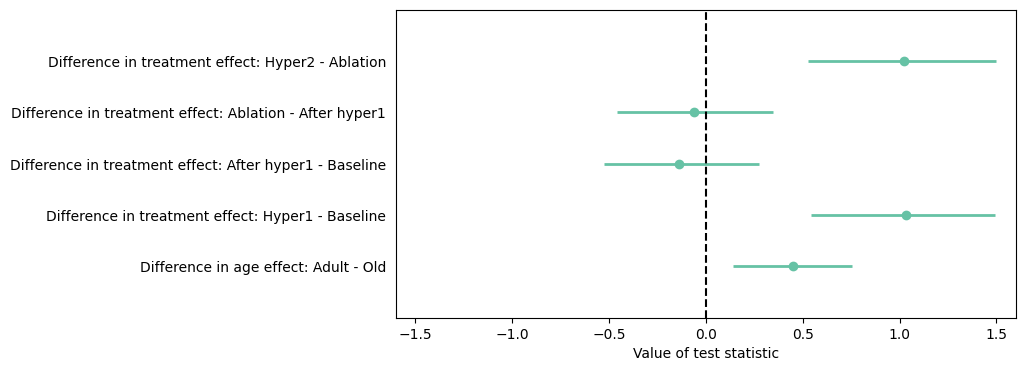

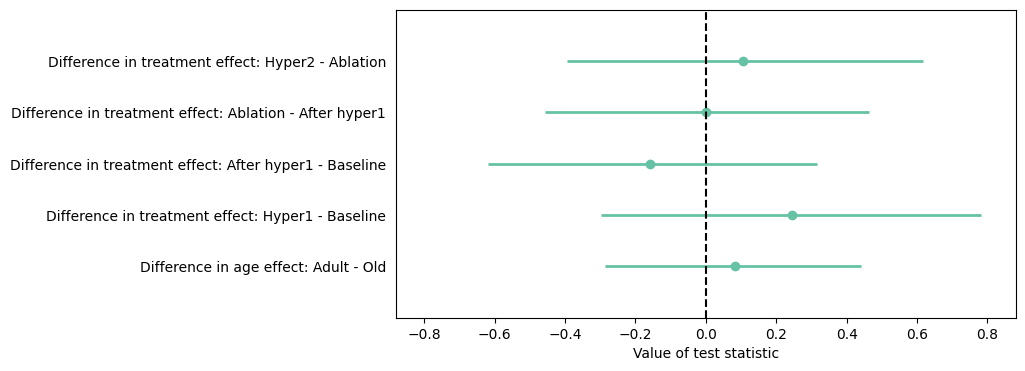

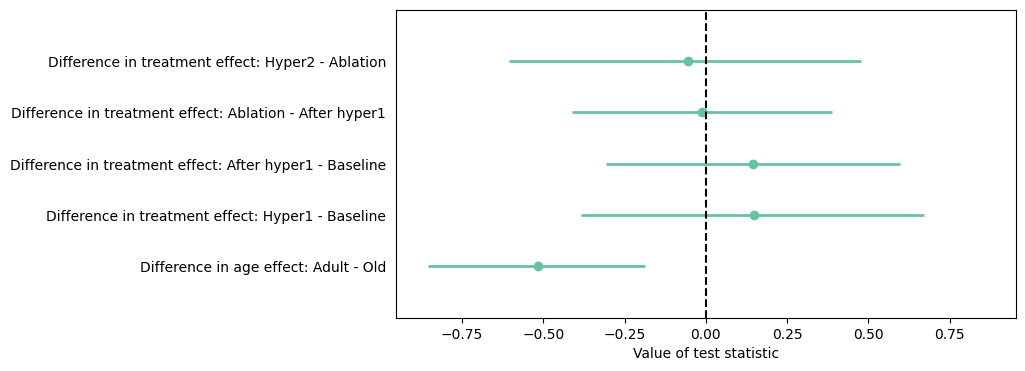

In [7]:
treatment_to_compare = {
    "hyper1": "baseline",
    "after_hyper1": "baseline",
    "ablation": "after_hyper1",
    "hyper2": "ablation",
}


for measurement_type in ["map", "pp", "hr"]:
    vcb = [
        ("a_age", "age", "adult"),
        ("a_treatment", "treatment", "baseline")
    ]
    age_ts = {
        "Difference in age effect: Adult - Old": idata_f1.posterior["a_age"].sel(measurement_type=measurement_type, age="adult") 
        - idata_f1.posterior["a_age"].sel(measurement_type=measurement_type, age="old")
    }
    treatment_ts = {
        f"Difference in treatment effect: {format_name(treatment)} - {format_name(treatment_to_compare[treatment])}": idata_f1.posterior["a_treatment"].sel(measurement_type=measurement_type, treatment=treatment) 
        - idata_f1.posterior["a_treatment"].sel(measurement_type=measurement_type, treatment=treatment_to_compare[treatment])
        for treatment in idata_f1.posterior.coords["treatment"].values if treatment != "baseline"
    }
    ts = age_ts | treatment_ts
    
    f, ax = plt.subplots(figsize=[8, 4])
    forestplot(ax, ts);
    save_figure(f, f"supporting-f1-effects-{measurement_type}")

/Users/tedgro/repos/teddygroves/sphincter/.venv/lib/python3.13/site-packages/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


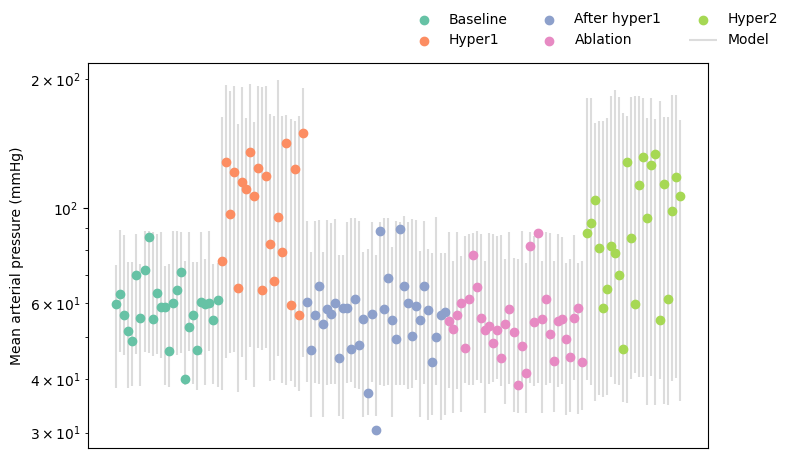

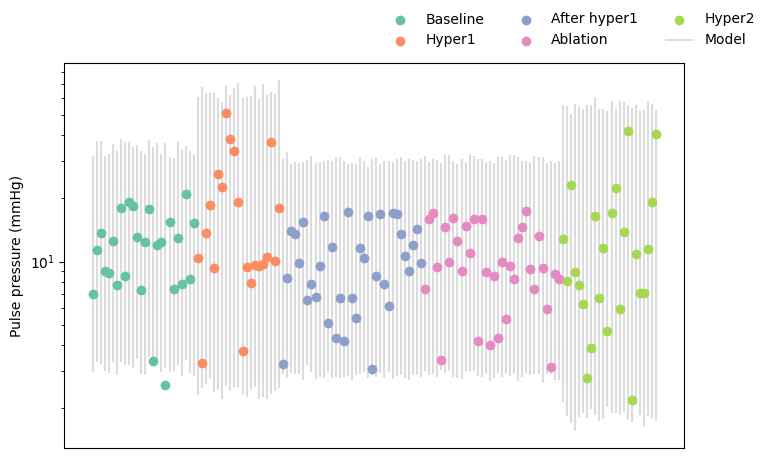

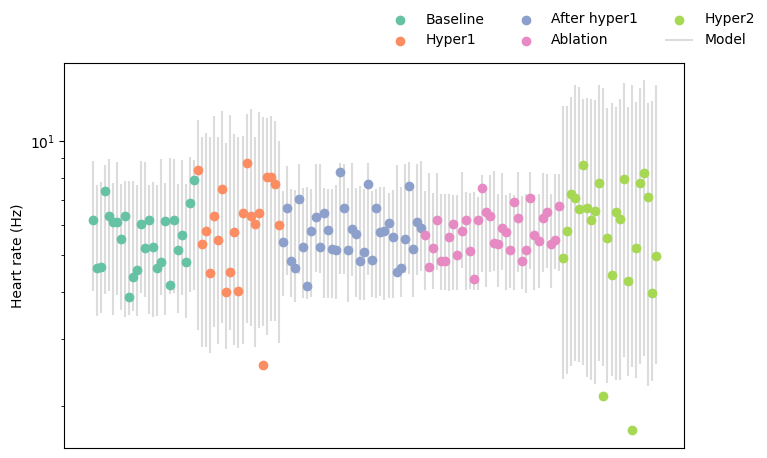

In [8]:
prepared_data_f1 = load_prepared_data("../data/prepared/pressure.json")
msts_f1 = prepared_data_f1.measurements

ylabels = [
    "Mean arterial pressure (mmHg)",
    "Pulse pressure (mmHg)",
    "Heart rate (Hz)"
]
yrep = idata_f1.posterior_predictive["yrep"]

for col, ylabel in zip(["map", "pp", "hr"], ylabels):
    f, ax = plt.subplots(figsize=[8, 5])
    plot_obs(ax, msts_f1[col], cat=msts_f1["treatment"]);
    plot_predictive(ax, yrep.sel(measurement_type=col), zorder=-1, cat=msts_f1["treatment"], label="model")
    ax.set(ylabel=ylabel)
    ax.set_xticks([])
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(map(format_name, labels), handles))
    f.legend(by_label.values(), by_label.keys(), frameon=False, ncol=3)
    ax.semilogy()
    #f.suptitle("Pressure measurements with posterior predictive intervals");
    save_figure(f, f"supporting-f1-ppc-{col}")


### Whisker stimulation (Figure 2)

In [9]:
prepared_data_f2 = load_prepared_data("../data/prepared/whisker.json")
msts_f2 = prepared_data_f2.measurements

idata_f2 = az.InferenceData.from_zarr(os.path.join("..", "inferences", "whisker-ind", "idata"))
idata_f2_big = az.InferenceData.from_zarr(os.path.join("..", "inferences", "whisker-big", "idata"))
idata_f2_big

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> sample_stats_prior
	> observed_data

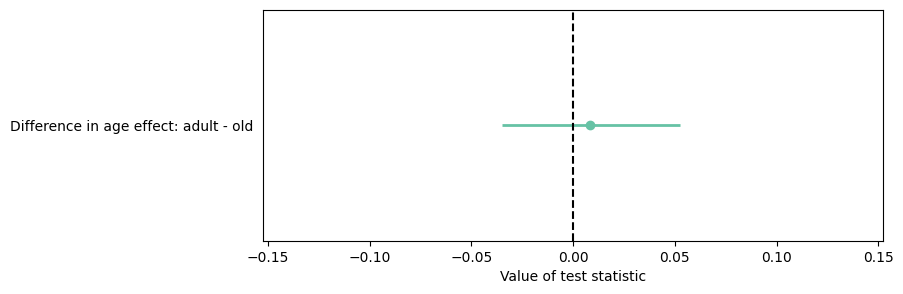

In [10]:
t = idata_f2.posterior["mu"].sel(age="adult") - idata_f2.posterior["mu"].sel(age="old")
f, ax = plt.subplots(figsize=[8, 3])
forestplot(ax, {"Difference in age effect: adult - old": t});

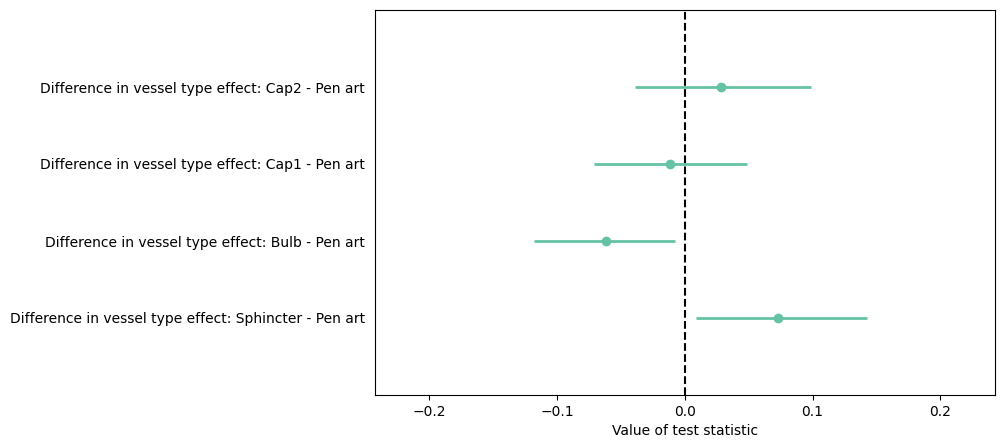

In [11]:
diff = {
    f"Difference in vessel type effect: {format_name(vt)} - {format_name('pen_art')}": (
        idata_f2.posterior["a_vessel_type"].sel(vessel_type=vt) 
        - idata_f2.posterior["a_vessel_type"].sel(vessel_type="pen_art")
    )
    for vt in ["sphincter", "bulb", "cap1", "cap2"]
}
f, ax = plt.subplots(figsize=[8, 5])
forestplot(ax, diff);

save_figure(f, "supporting-f2-effects-vesseltype")

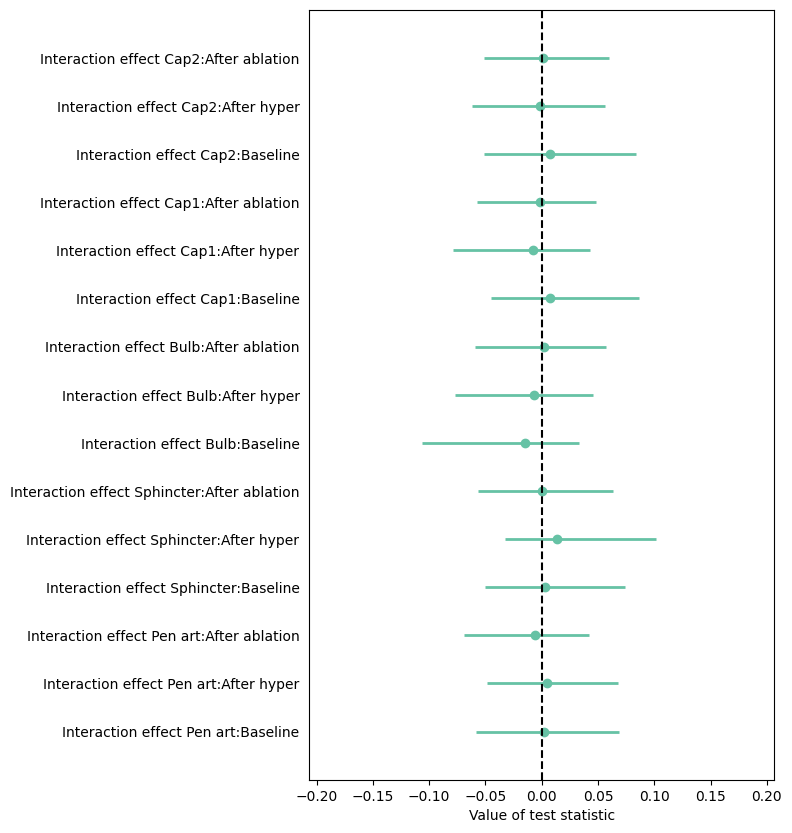

In [12]:
f, ax = plt.subplots(figsize=[6, 10])
t = {
    f"Interaction effect {format_name(vt)}:{format_name(t)}": (
        idata_f2_big.posterior["a_vessel_type_treatment"].sel(vessel_type=vt, treatment=t)
    )
    for vt in idata_f2_big.posterior.coords["vessel_type"].values
    for t in idata_f2_big.posterior.coords["treatment"].values
}
forestplot(ax, t);
save_figure(f, "supporting-f2-effects-vesseltype-treatment")

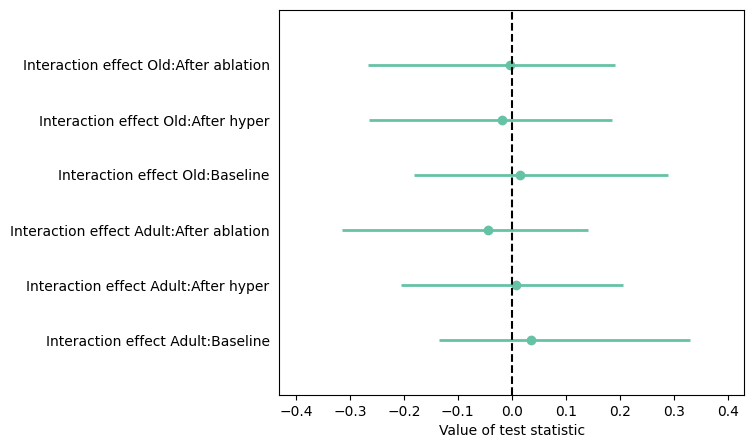

In [13]:
f, ax = plt.subplots(figsize=[6, 5])
t = {
    f"Interaction effect {format_name(age)}:{format_name(t)}": (
        idata_f2_big.posterior["a_age_treatment"].sel(age=age, treatment=t)
    )
    for age in idata_f2_big.posterior.coords["age"].values
    for t in idata_f2_big.posterior.coords["treatment"].values
}
forestplot(ax, t);
save_figure(f, "supporting-f2-effects-age-treatment")

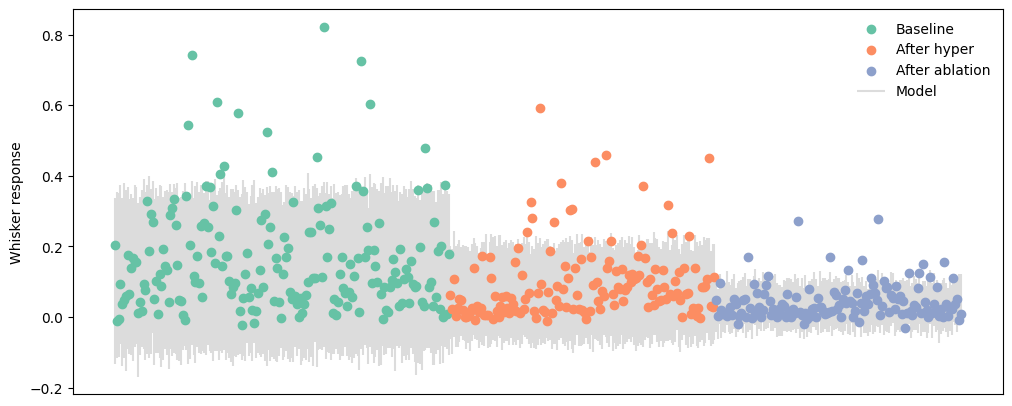

In [14]:
f, ax = plt.subplots(figsize=[12, 5])
plot_obs(ax, msts_f2["diam_log_ratio"], cat=msts_f2["treatment"])
plot_predictive(ax, idata_f2.posterior_predictive["yrep"], cat=msts_f2["treatment"], zorder=-1, label="model")
ax.set(ylabel="Whisker response")
ax.set_xticks([])
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(map(format_name, labels), handles))
ax.legend(by_label.values(), by_label.keys(), frameon=False)
save_figure(f, "supporting-f2-ppc")

In [15]:
comparison = az.compare({"big": idata_f2_big, "ind": idata_f2})
comparison

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
ind,0,353.161294,50.556109,0.00000,0.838275,40.503952,0.000000,False,log
big,1,349.655525,66.412393,3.50577,0.161725,40.249855,3.231317,False,log


## Figure 3

In [16]:
prepped_f3 = load_prepared_data("../data/prepared/hypertension.json")
msts_f3 = prepped_f3.measurements
idata_f3_big = az.InferenceData.from_zarr(os.path.join("..", "inferences", "hypertension-big", "idata"))
idata_f3_basic = az.InferenceData.from_zarr(os.path.join("..", "inferences", "hypertension-basic", "idata"))
idata_f3_big

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> sample_stats_prior
	> observed_data

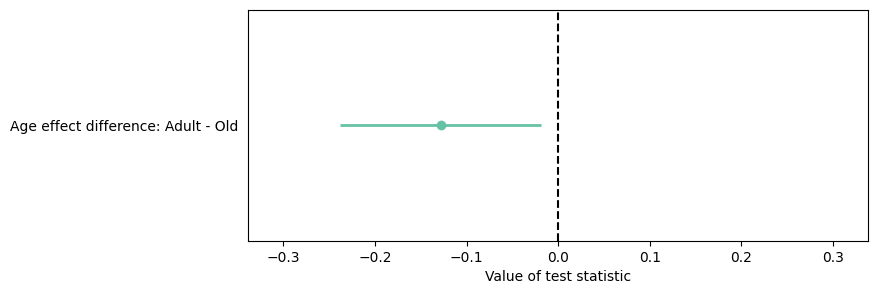

In [17]:
t = {
    "Age effect difference: Adult - Old": (
        idata_f3_basic.posterior["mu"].sel(age="adult")
        - idata_f3_basic.posterior["mu"].sel(age="old")
    )
}
f, ax = plt.subplots(figsize=[8, 3])
forestplot(ax, t);
save_figure(f, "supporting-f3-effects-age")

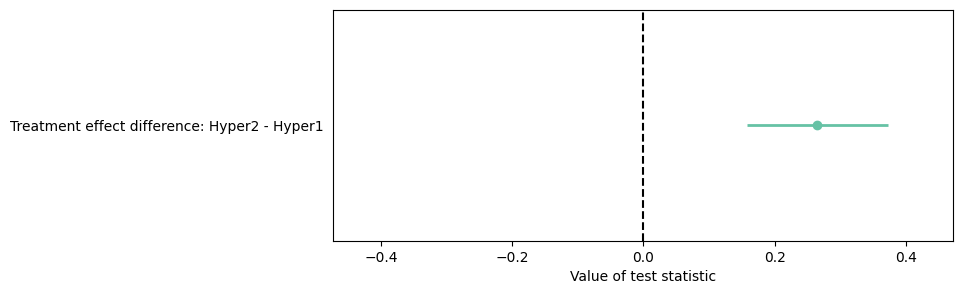

In [18]:
t = {
    f"Treatment effect difference: {format_name('hyper2')} - {format_name('hyper1')}": (
        idata_f3_basic.posterior["a_treatment"].sel(treatment="hyper2")
        - idata_f3_basic.posterior["a_treatment"].sel(treatment="hyper1")
    )
}
f, ax = plt.subplots(figsize=[8, 3])
forestplot(ax, t);
save_figure(f, "supporting-f3-effects-hyper1hyper2")

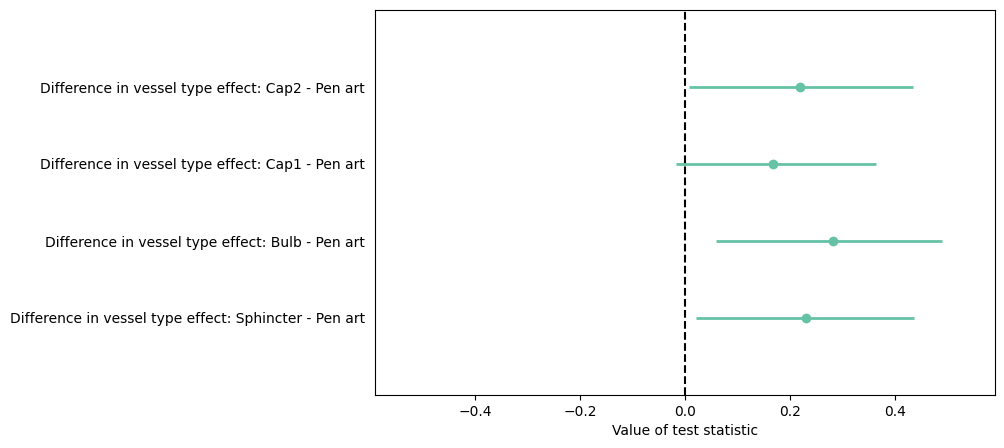

In [19]:
diff = {
    f"Difference in vessel type effect: {format_name(vt)} - {format_name('pen_art')}": (
        idata_f3_basic.posterior["a_vessel_type"].sel(vessel_type=vt) 
        - idata_f3_basic.posterior["a_vessel_type"].sel(vessel_type="pa")
    )
    for vt in ["sphincter", "bulb", "cap1", "cap2"]
}
f, ax = plt.subplots(figsize=[8, 5])
forestplot(ax, diff);

save_figure(f, "supporting-f3-effects-vesseltype")

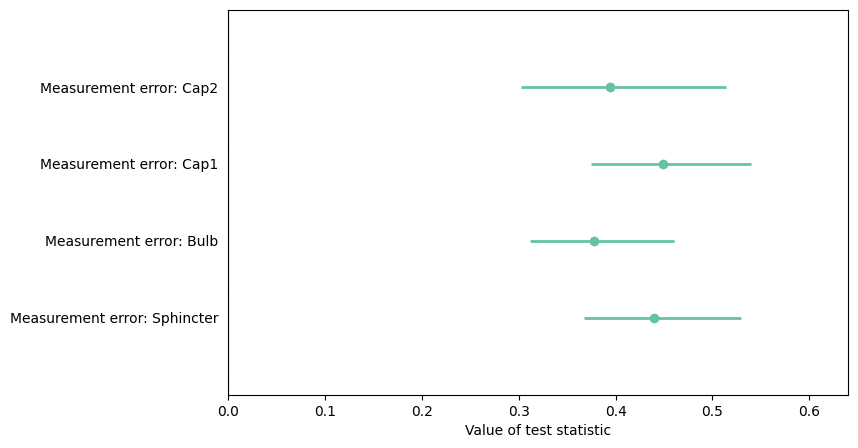

In [20]:
t = {
    f"Measurement error: {format_name(vt)}": idata_f3_basic.posterior["sigma"].sel(vessel_type=vt) 
    for vt in ["sphincter", "bulb", "cap1", "cap2"]
}
f, ax = plt.subplots(figsize=[8, 5])
forestplot(ax, t);
ax.set_xlim(0, ax.get_xlim()[1])

save_figure(f, "supporting-f3-sds")

## figure 4

In [21]:
idata_f4_basic_speed = az.from_zarr(os.path.join("..", "inferences", "flow-basic-speed", "idata"))
idata_f4_basic_flux = az.from_zarr(os.path.join("..", "inferences", "flow-basic-flux", "idata"))
idata_f4_big_speed = az.from_zarr(os.path.join("..", "inferences", "flow-big-speed", "idata"))
idata_f4_big_flux = az.from_zarr(os.path.join("..", "inferences", "flow-big-flux", "idata"))

prepped_f4_speed = load_prepared_data("../data/prepared/flow-speed.json")
prepped_f4_flux = load_prepared_data("../data/prepared/flow-flux.json")

msts_f4_speed = prepped_f4_speed.measurements
msts_f4_flux = prepped_f4_flux.measurements

idata_f4_basic_speed

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> sample_stats_prior
	> observed_data

In [22]:
speed_comp = az.compare({"big": idata_f4_big_speed, "basic": idata_f4_basic_speed})
flux_comp = az.compare({"big": idata_f4_big_flux, "basic": idata_f4_basic_flux})

cols = ["elpd_loo", "se", "elpd_diff", "dse"]
display(speed_comp[cols])
display(flux_comp[cols])

/Users/tedgro/repos/teddygroves/sphincter/.venv/lib/python3.13/site-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
arviz - WARNING - Array contains NaN-value.


,elpd_loo,se,elpd_diff,dse
basic,-207.180222,19.093763,0.000000,0.000000
big,-207.549353,19.079168,0.369131,1.166329


,elpd_loo,se,elpd_diff,dse
basic,-181.333978,29.206468,0.000000,0.000000
big,-182.760611,29.425505,1.426633,0.920142


In [23]:
idata_f4_basic_flux.posterior.coords["vessel_type"].values

array(['cap2', 'cap3', 'cap4', 'cap5', 'sphincter'], dtype='<U9')

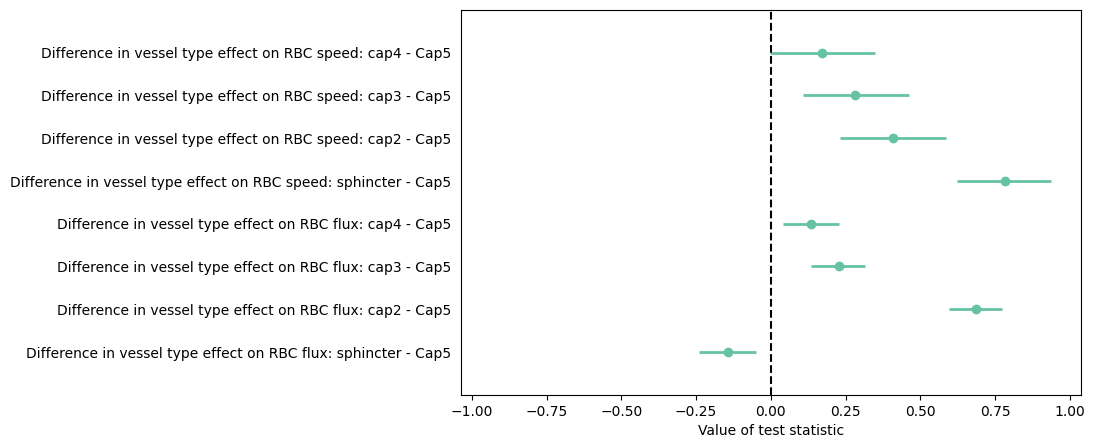

In [24]:
comparison = "cap5"
vts = ["sphincter", "cap2", "cap3", "cap4", "cap5"]
t = {
    f"Difference in vessel type effect on RBC flux: {vt} - {format_name(comparison)}": (
        idata_f4_basic_flux.posterior["a_vessel_type"].sel(vessel_type=vt)
        - idata_f4_basic_flux.posterior["a_vessel_type"].sel(vessel_type=comparison)
    )
    for vt in vts if vt != comparison

} | {
     f"Difference in vessel type effect on RBC speed: {vt} - {format_name(comparison)}": (
        idata_f4_basic_speed.posterior["a_vessel_type"].sel(vessel_type=vt)
        - idata_f4_basic_speed.posterior["a_vessel_type"].sel(vessel_type=comparison)
    )
    for vt in vts if vt != comparison
}
f, ax = plt.subplots(figsize=[8, 5])
forestplot(ax, t);
save_figure(f, "supporting-f4-effects-vesseltype")


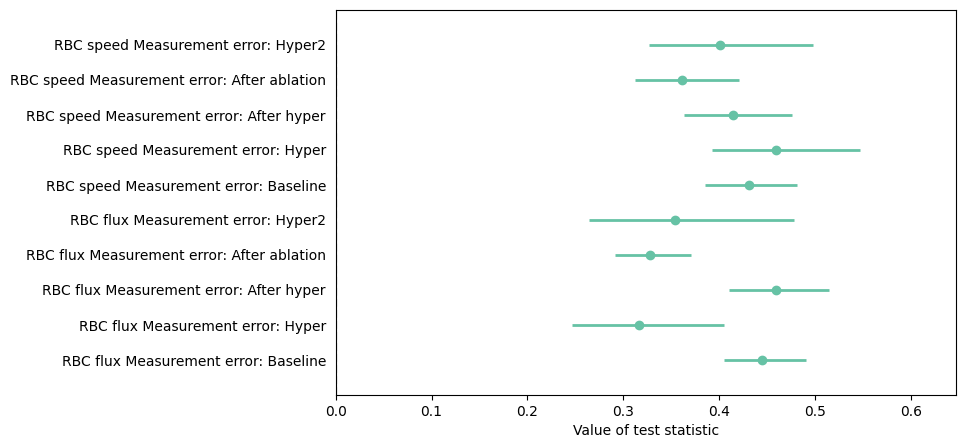

In [25]:
t = {
    f"RBC {mt} Measurement error: {format_name(treatment)}": idata.posterior["sigma"].sel(treatment=treatment) 
    for mt, idata in [("flux", idata_f4_basic_flux), ("speed", idata_f4_basic_speed)]
    for treatment in idata.posterior.coords["treatment"].values

}
f, ax = plt.subplots(figsize=[8, 5])
forestplot(ax, t);
ax.set_xlim(0, ax.get_xlim()[1])

save_figure(f, "supporting-f4-sds")

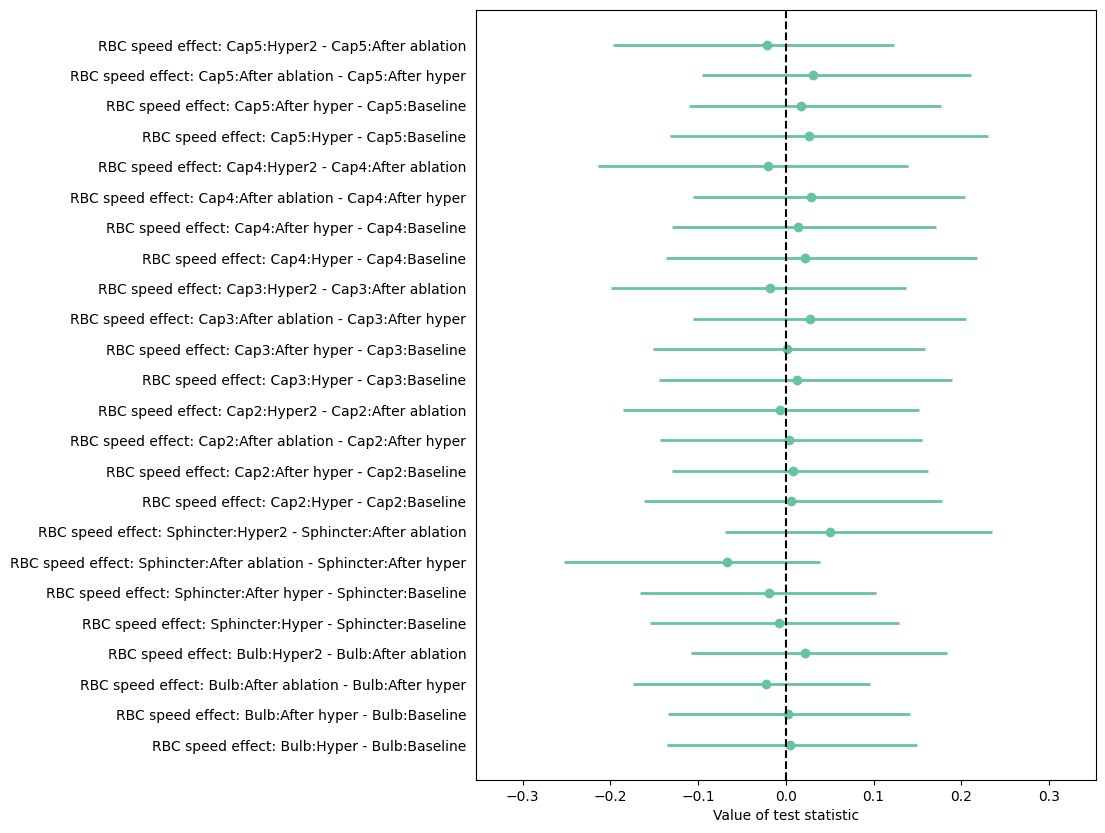

In [42]:
vts = ["bulb", "sphincter", "cap2", "cap3", "cap4", "cap5"]
treatments = ["hyper", "after_hyper", "after_ablation", "hyper2"]
treatment_to_compare = {
    "hyper": "baseline",
    "after_hyper": "baseline",
    "after_ablation": "after_hyper",
    "hyper2": "after_ablation",
}
t = {
    f"RBC speed effect: {format_name(vt)}:{format_name(treatment)} - {format_name(vt)}:{format_name(treatment_to_compare[treatment])}": (
        idata_f4_big_speed.posterior["a_vessel_type_treatment"].sel(vessel_type=vt, treatment=treatment)
        - idata_f4_big_speed.posterior["a_vessel_type_treatment"].sel(vessel_type=vt, treatment=treatment_to_compare[treatment])
    )   
    for vt in vts
    for treatment in treatments
}
f, ax = plt.subplots(figsize=[8, 10], sharex=True)
forestplot(ax, t);
save_figure(f, "supporting-f4-interaction-effects-speed")

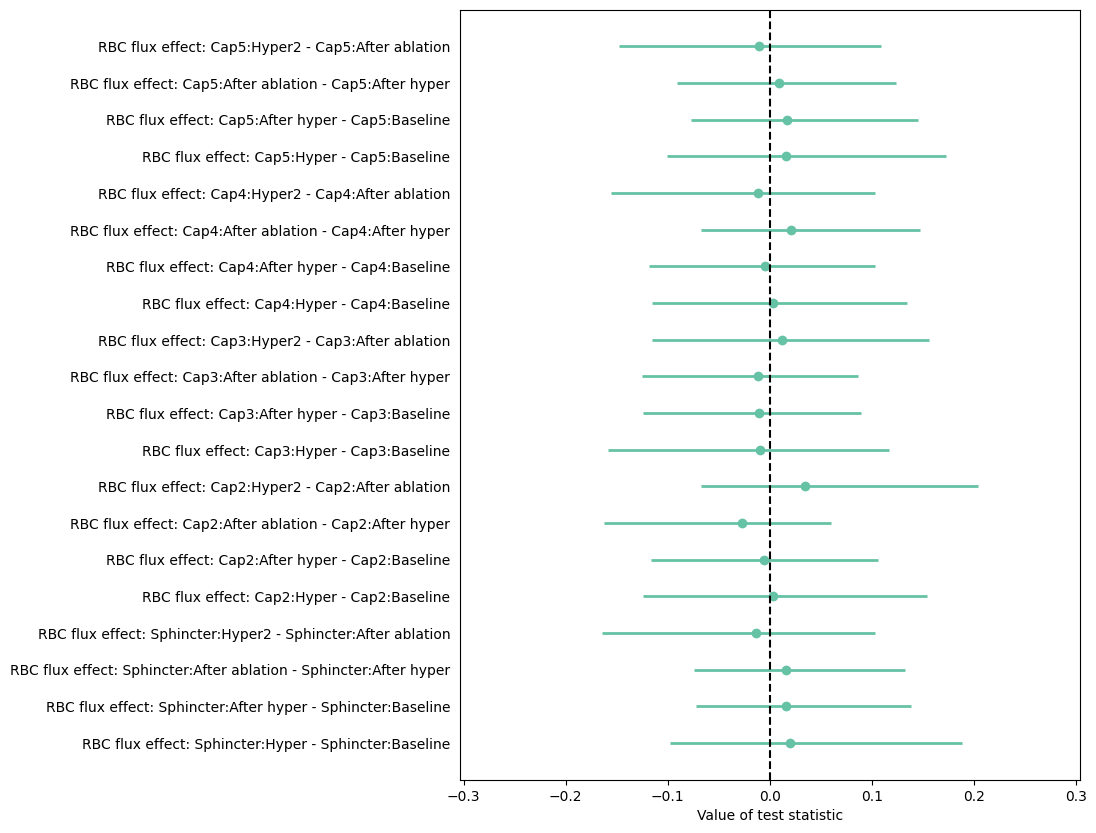

In [27]:
vts = ['sphincter', 'cap2', 'cap3', 'cap4', 'cap5']
treatments = ['hyper', 'after_hyper', 'after_ablation', 'hyper2']
t = {
    f"RBC flux effect: {format_name(vt)}:{format_name(treatment)} - {format_name(vt)}:{format_name(treatment_to_compare[treatment])}": (
        idata_f4_big_flux.posterior["a_vessel_type_treatment"].sel(vessel_type=vt, treatment=treatment)
        - idata_f4_big_flux.posterior["a_vessel_type_treatment"].sel(vessel_type=vt, treatment=treatment_to_compare[treatment])
    )   
    for vt in vts
    for treatment in treatments
}
f, ax = plt.subplots(figsize=[8, 10], sharex=True)
forestplot(ax, t);
save_figure(f, "supporting-f4-interaction-effects-flux")

## Figure 5

In [28]:
idata_f5 = az.InferenceData.from_zarr(os.path.join("..", "inferences", "pulsatility-basic-full", "idata"))
data_f5 = load_prepared_data("../data/prepared/pulsatility.json")
msts_f5 = data_f5.measurements



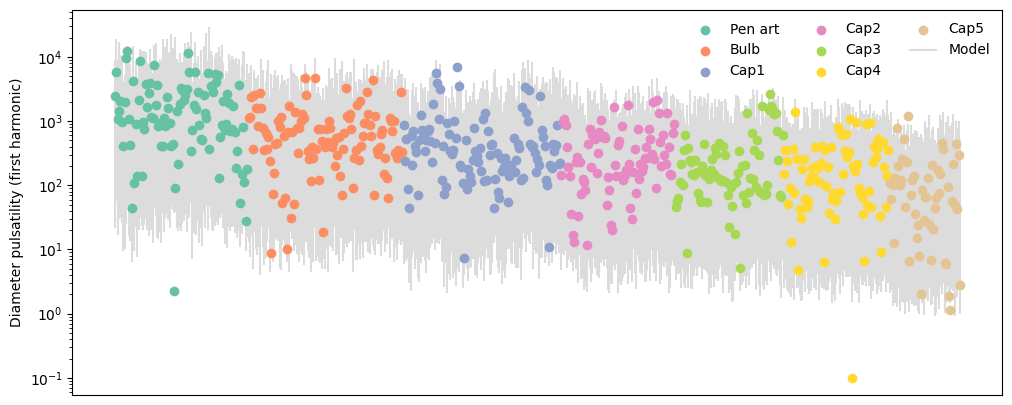

In [29]:
f, ax = plt.subplots(figsize=[12, 5])
plot_obs(ax, msts_f5["pd1"], cat=msts_f5["vessel_type"]);
plot_predictive(ax, idata_f5.posterior_predictive["yrep"].sel(measurement_type="diameter"), cat=msts_f5["vessel_type"], zorder=-1, label="model")
ax.semilogy()
ax.set(ylabel="Diameter pulsatility (first harmonic)")
ax.set_xticks([]);
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(map(format_name, labels), handles))
ax.legend(by_label.values(), by_label.keys(), frameon=False, ncol=3);
save_figure(f, "supporting-f5-ppc-diameter")

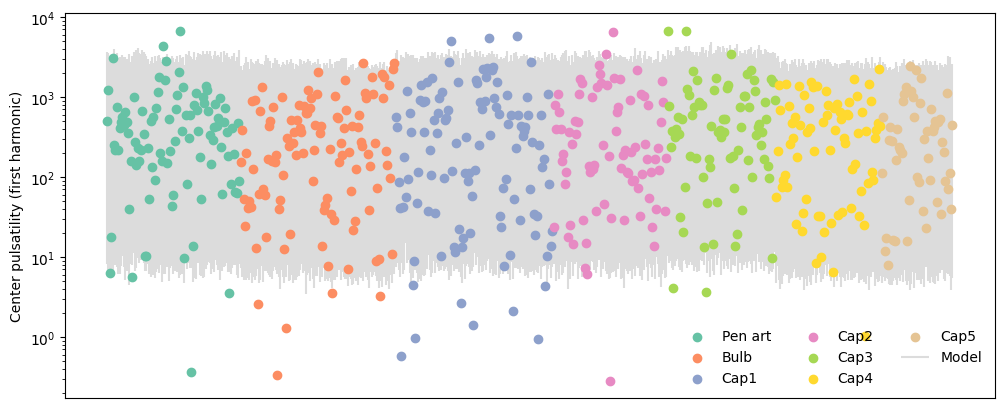

In [30]:
f, ax = plt.subplots(figsize=[12, 5])
plot_obs(ax, msts_f5["pc1"], cat=msts_f5["vessel_type"]);
plot_predictive(ax, idata_f5.posterior_predictive["yrep"].sel(measurement_type="center"), cat=msts_f5["vessel_type"], zorder=-1, label="model")
ax.semilogy()
ax.set(ylabel="Center pulsatility (first harmonic)")
ax.set_xticks([])
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(map(format_name, labels), handles))
ax.legend(by_label.values(), by_label.keys(), frameon=False, ncol=3);
save_figure(f, "supporting-f5-ppc-center")

In [31]:
idata_f5

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> sample_stats_prior
	> observed_data

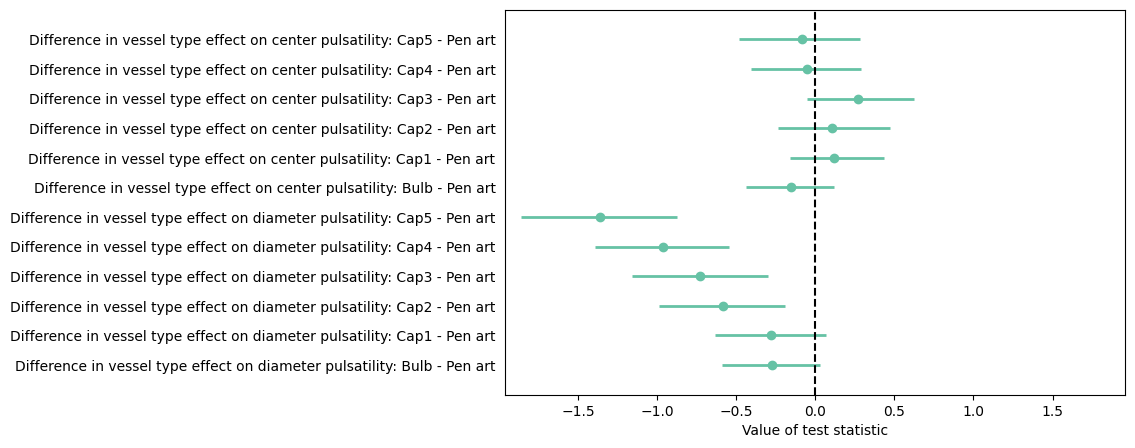

In [32]:
comparison = "pen_art"
vts = ["pen_art", "bulb", "cap1", "cap2", "cap3", "cap4", "cap5"]
t = {
    f"Difference in vessel type effect on diameter pulsatility: {format_name(vt)} - {format_name(comparison)}": (
        idata_f5.posterior["a_vessel_type"].sel(measurement_type="diameter", vessel_type=vt)
        - idata_f5.posterior["a_vessel_type"].sel(measurement_type="diameter", vessel_type=comparison)
    )
    for vt in vts if vt != comparison

} | {
     f"Difference in vessel type effect on center pulsatility: {format_name(vt)} - {format_name(comparison)}": (
        idata_f5.posterior["a_vessel_type"].sel(measurement_type="center", vessel_type=vt)
        - idata_f5.posterior["a_vessel_type"].sel(measurement_type="center", vessel_type=comparison)
    )
    for vt in vts if vt != comparison
}
f, ax = plt.subplots(figsize=[8, 5])
forestplot(ax, t);
save_figure(f, "supporting-f5-effects-vesseltype")


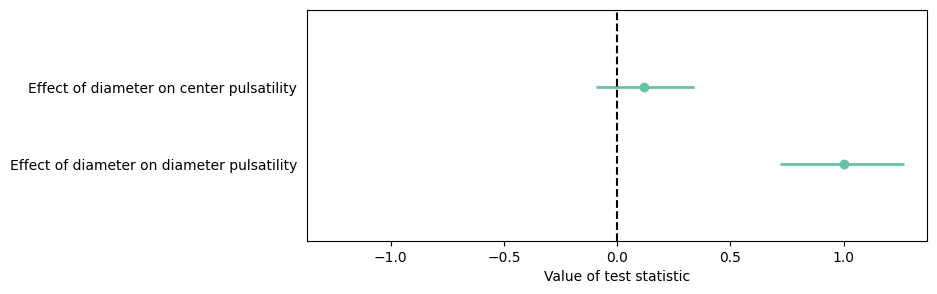

In [33]:

t = {
    f"Effect of diameter on diameter pulsatility": idata_f5.posterior["b_diameter"].sel(measurement_type="diameter"),
    f"Effect of diameter on center pulsatility": idata_f5.posterior["b_diameter"].sel(measurement_type="center"),
}
f, ax = plt.subplots(figsize=[8, 3])
forestplot(ax, t);
save_figure(f, "supporting-f5-effects-diameter")


## Figure 6

In [34]:
idata_f6 = az.InferenceData.from_zarr(os.path.join("..", "inferences", "diameter", "idata"))
prepared_data_f6 = load_prepared_data(os.path.join("..", "data", "prepared", "pulsatility.json"))
msts_f6 = prepared_data_f6.measurements
idata_f6

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> sample_stats_prior
	> observed_data

In [35]:
msts_f6.groupby(["treatment", "vessel_type"]).size().unstack()

/var/folders/54/_lktxzc17zd8hbm440mnyjgw0000gp/T/ipykernel_24421/2561496676.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  msts_f6.groupby(["treatment", "vessel_type"]).size().unstack()


vessel_type,pen_art,bulb,cap1,cap2,cap3,cap4,cap5
treatment,,,,,,,
baseline,26,33,32,34,31,34,25
hyper,18,22,15,0,0,0,0
after_hyper,24,28,32,26,27,24,16
after_ablation,18,17,20,21,19,17,10
hyper2,9,10,13,0,0,0,0


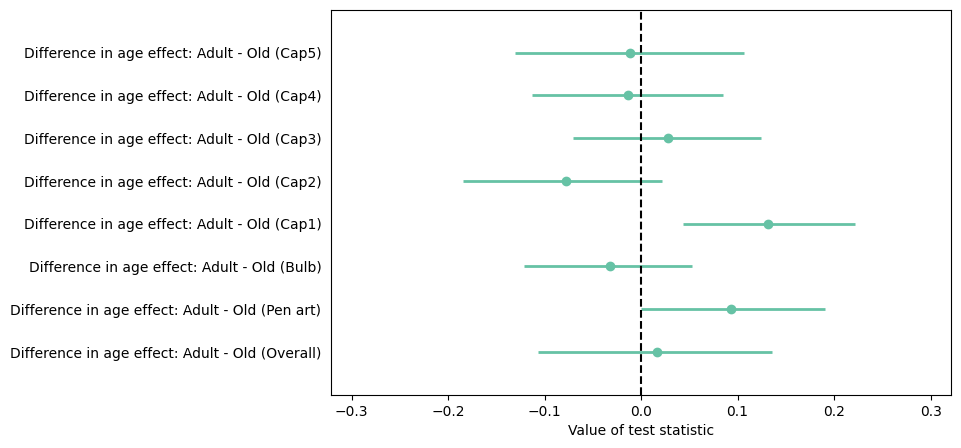

In [36]:
t_overall = {
    "Difference in age effect: Adult - Old (Overall)" : (
        idata_f6.posterior["mu"].sel(age="adult")
        - idata_f6.posterior["mu"].sel(age="old")
    )
}
t_vt = {
    f"Difference in age effect: Adult - Old ({format_name(vt)})": (
        idata_f6.posterior["mu"].sel(age="adult") - idata_f6.posterior["mu"].sel(age="old")
        + idata_f6.posterior["a_age_vessel_type"].sel(age="adult", vessel_type=vt)
        - idata_f6.posterior["a_age_vessel_type"].sel(age="old", vessel_type=vt)
    )
    for vt in idata_f6.posterior.coords["vessel_type"].values
}
t = t_overall | t_vt
f, ax = plt.subplots(figsize=[8, 5])
forestplot(ax, t);
save_figure(f, "supporting-f6-effects-age")

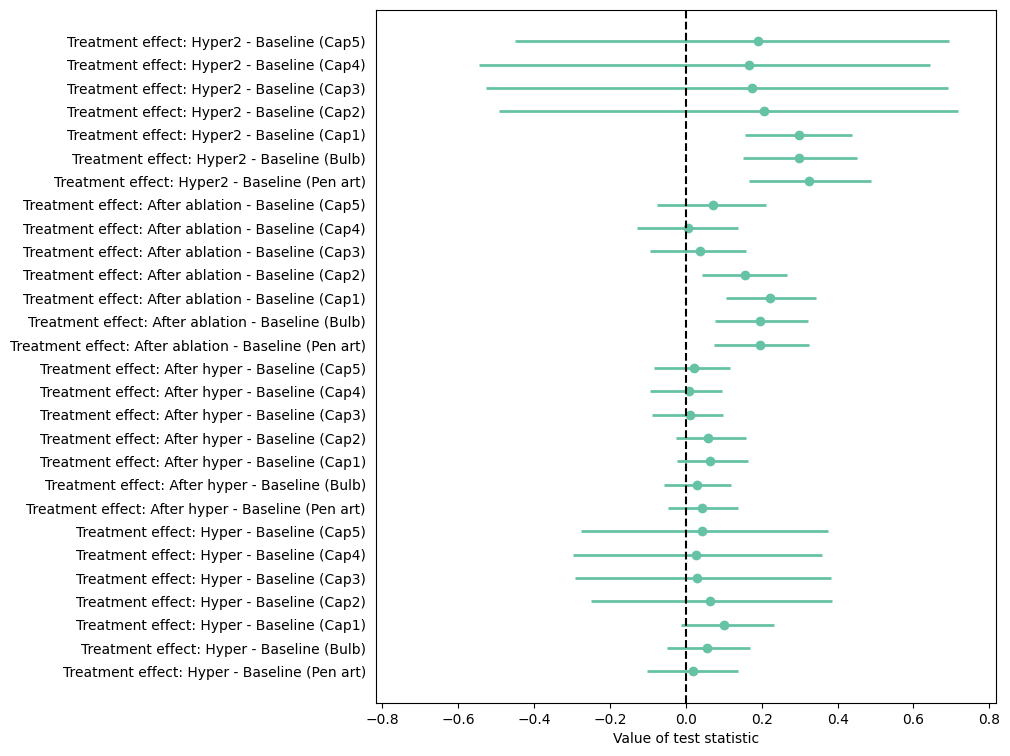

In [37]:
t = {
    f"Treatment effect: {format_name(treatment)} - Baseline ({format_name(vt)})": (
        idata_f6.posterior["a_treatment"].sel(treatment=treatment) 
        - idata_f6.posterior["a_treatment"].sel(treatment="baseline")
        + idata_f6.posterior["a_vessel_type_treatment"].sel(treatment=treatment, vessel_type=vt)
        - idata_f6.posterior["a_vessel_type_treatment"].sel(treatment="baseline", vessel_type=vt)
    )
    for treatment in idata_f6.posterior.coords["treatment"].values
    for vt in idata_f6.posterior.coords["vessel_type"].values
    if treatment != "baseline"
}
f, ax = plt.subplots(figsize=[8, 9])
forestplot(ax, t);

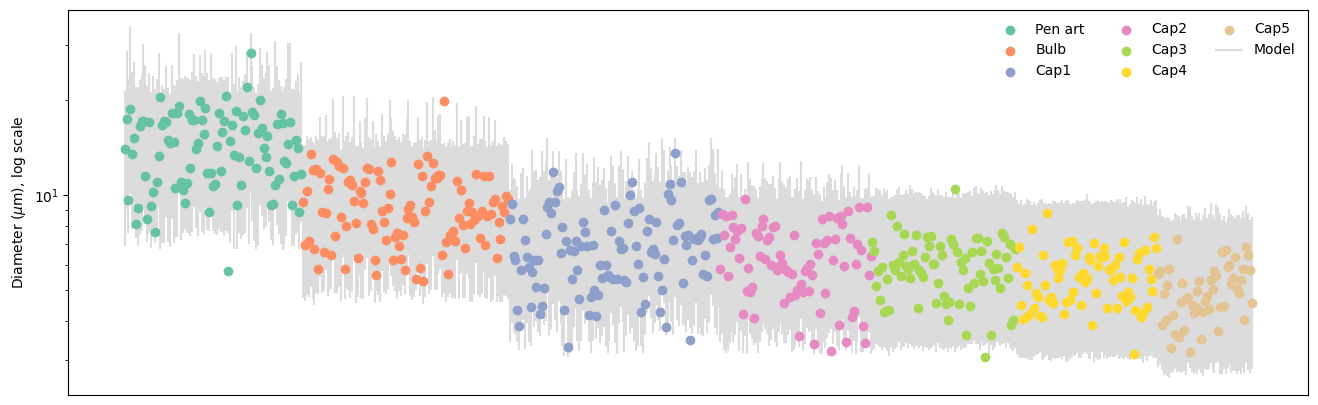

In [38]:
yrep = idata_f6.posterior_predictive["yrep"]

f, ax = plt.subplots(1, 1, figsize=[16, 5])

plot_obs(ax, msts_f6["diameter"], cat=msts_f6["vessel_type"]);
plot_predictive(ax, yrep, zorder=-1, cat=msts_f6["vessel_type"], label="model")
ax.legend(frameon=False);
ax.semilogy();
ax.set_xticks([])
ax.set(ylabel="Diameter ($\\mu$m), log scale")
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(map(format_name, labels), handles))
ax.legend(by_label.values(), by_label.keys(), frameon=False, ncol=3);
save_figure(f, "supporting-f6-ppc")

## Figure 7

In [39]:
idata_f7_density = az.from_netcdf(os.path.join("..", "inferences", "collaterals", "ctls_per_area.nc"))
idata_f7_diameter = az.from_netcdf(os.path.join("..", "inferences", "collaterals", "ln_diameter_mean.nc"))
idata_f7_curved_length = az.from_netcdf(os.path.join("..", "inferences", "collaterals", "ln_curved_length.nc"))
idata_f7_tortuosity = az.from_netcdf(os.path.join("..", "inferences", "collaterals", "ln_m1_tortuosity.nc"))

msts_f7_ctls = pd.read_csv(os.path.join("..", "data", "prepared", "collaterals.csv"))
msts_f7_mice = pd.read_csv(os.path.join("..", "data", "prepared", "collaterals-mice.csv"))
msts_f7_mice.head()

,Date,mouse_id,age,craniotomy_area,collaterals,collaterals_per_area,ln_collaterals_per_area
0,11020,11020,adult,6.312420,6,0.950507,-0.050760
1,40520,40520,adult,4.892264,5,1.022022,0.021783
2,41021,41021,old,7.024126,1,0.142366,-1.949351
3,50520,50520,old,6.257000,3,0.479463,-0.735089
4,51020,51020,adult,6.370858,6,0.941788,-0.059975


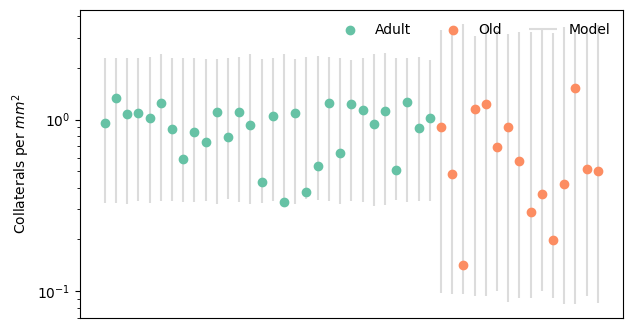

In [40]:
f, ax = plt.subplots(1, 1, figsize=[7, 4])

yrep = np.exp(idata_f7_density.posterior_predictive["ln_collaterals_per_area"])
plot_obs(ax, msts_f7_mice["collaterals_per_area"], cat=msts_f7_mice["age"]);
plot_predictive(ax, yrep, zorder=-1, cat=msts_f7_mice["age"], label="model");
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(map(format_name, labels), handles))
ax.semilogy()
ax.set_xticks([])
ax.set_ylabel("Collaterals per $mm^2$");
ax.legend(by_label.values(), by_label.keys(), frameon=False, ncol=3);
save_figure(f, "supporting-f7-ppc-density")

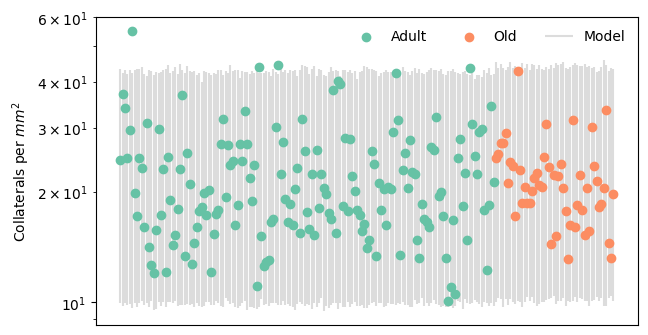

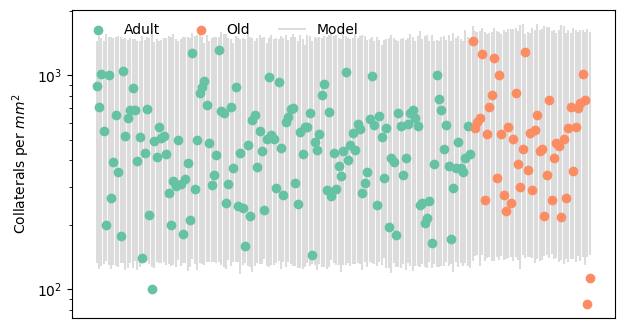

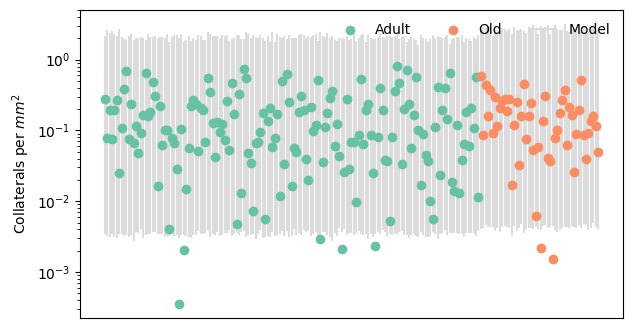

In [41]:
ycol_to_title = {
    "ln_diameter_mean": "Diameter",
    "ln_curved_length": "Length",
    "ln_m1_tortuosity": "Tortuosity minus 1"
}

for (ycol, title), idata in zip(
    ycol_to_title.items(), 
    [idata_f7_diameter, idata_f7_curved_length, idata_f7_tortuosity]
):
    f, ax = plt.subplots(figsize=[7, 4])
    y = np.exp(msts_f7_ctls[ycol])
    yrep = np.exp(idata.posterior_predictive[ycol])
    plot_obs(ax, y, cat=msts_f7_ctls["age"]);
    plot_predictive(ax, yrep, zorder=-1, cat=msts_f7_ctls["age"], label="model");
    ax.semilogy()
    ax.set_ylabel(title)
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(map(format_name, labels), handles))
    ax.semilogy()
    ax.set_xticks([])
    ax.set_ylabel("Collaterals per $mm^2$");
    ax.legend(by_label.values(), by_label.keys(), frameon=False, ncol=3);
    save_figure(f, f"supporting-f7-ppc-{title.lower().replace(" ", "-")}")